<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week18_deeplearning_cv/ch18_2_cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch 18_2 CNN MNIST Classifier

이전 챕터에선 Convolution Neural Network의 기본 개념에 대해서 알아보았습니다. 이번 챕터에서는 직접 torch를 이용하여 손글씨를 분류하는 모델을 만들어보겠습니다.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

batch_size = 32
train_dataset = MNIST(root="data", train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root="data", train=False, download=True, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## CNN Classifier

### 모델 작성

간단한 CNN 모델 클래스를 만들어 보겠습니다.

In [ ]:
import torch
from torch import nn


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same")
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same")
        self.fc = nn.Linear(in_features=784, out_features=10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.softmax(self.fc(x))
        return x

In [ ]:
model = SimpleCNN()

In [ ]:
!pip install torchsummary

In [ ]:
for batch in train_dataloader:
    print(batch[0].shape)
    break

torch.Size([32, 1, 28, 28])


In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                   [-1, 10]           7,850
           Softmax-8                   [-1, 10]               0
Total params: 9,098
Trainable params: 9,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.03
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 모델 학습

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = accuracy_score(y_train, pred)
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = accuracy_score(y_val, pred)
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
logs = train_validate_model(model)

100%|██████████| 313/313 [00:02<00:00, 133.61it/s]


epoch 1 train - loss: 1.6051 acc: 0.8658 val - loss: 1.5042 acc: 0.9599


100%|██████████| 313/313 [00:02<00:00, 129.65it/s]


epoch 2 train - loss: 1.4983 acc: 0.9652 val - loss: 1.4903 acc: 0.9727


100%|██████████| 313/313 [00:02<00:00, 145.64it/s]


epoch 3 train - loss: 1.4896 acc: 0.9729 val - loss: 1.4906 acc: 0.9722


100%|██████████| 313/313 [00:02<00:00, 137.81it/s]


epoch 4 train - loss: 1.4848 acc: 0.9775 val - loss: 1.4829 acc: 0.9795


100%|██████████| 313/313 [00:03<00:00, 104.19it/s]


epoch 5 train - loss: 1.4827 acc: 0.9789 val - loss: 1.4821 acc: 0.9804


100%|██████████| 313/313 [00:02<00:00, 133.17it/s]


epoch 6 train - loss: 1.4806 acc: 0.9812 val - loss: 1.4787 acc: 0.9828


100%|██████████| 313/313 [00:02<00:00, 145.37it/s]


epoch 7 train - loss: 1.4789 acc: 0.9826 val - loss: 1.4789 acc: 0.9828


100%|██████████| 313/313 [00:02<00:00, 143.87it/s]


epoch 8 train - loss: 1.4781 acc: 0.9836 val - loss: 1.4789 acc: 0.9829


100%|██████████| 313/313 [00:02<00:00, 140.37it/s]


epoch 9 train - loss: 1.4767 acc: 0.985 val - loss: 1.4779 acc: 0.9837


100%|██████████| 313/313 [00:02<00:00, 141.00it/s]

epoch 10 train - loss: 1.4759 acc: 0.9855 val - loss: 1.4766 acc: 0.9853


### 결과 시각화

In [ ]:
from matplotlib import pyplot as plt

def plot_loss_acc(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

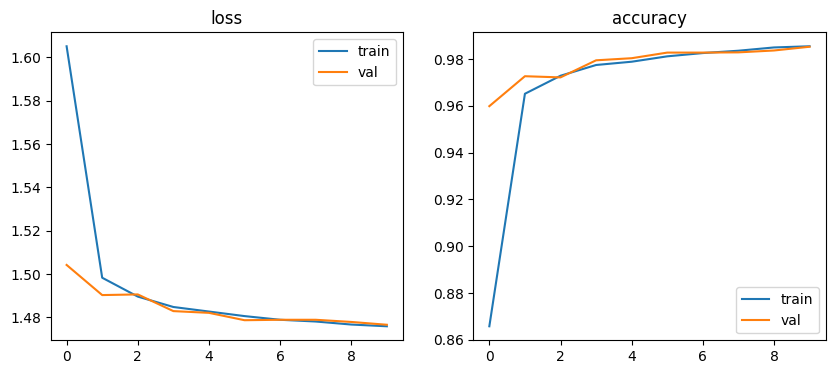

In [ ]:
plot_loss_acc(logs)

## 정리

이번 챕터에서는 간단한 CNN으로 MNIST 이미지 분류 모델을 만들어보았습니다. 그 결과 비교적 적은 파라미터로 98% 정확도에 달하는 모델을 만들 수 있었습니다.